# **Modelo de Classificação**

# Requisitos

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from IPython.display import Markdown


# Pré-processamento e Modelagem
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Métricas de Avaliação
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Para garantir a reprodutibilidade
RANDOM_STATE = 42

# Carregamento e Preparação dos Dados

## Carregamento da base de dados

In [ ]:
# Carregamento do arquivo
df = pd.read_csv("https://raw.githubusercontent.com/Jessicamsza/analise-sentimentos-reviews-olist/refs/heads/main/data/olist_order_reviews_dataset.csv")

# Manter apenas reviews que POSSUEM um comentário escrito
df_com_texto = df.dropna(subset=['review_comment_message']).copy()
print(f"Número de registros após remover nulos: {len(df_com_texto)}")

#Ignorar as notas 3 (neutras)
df_filtrado = df_com_texto[df_com_texto['review_score'] != 3].copy()
print(f"Número de registros após remover notas 3: {len(df_filtrado)}")

Número de registros após remover nulos: 40977
Número de registros após remover notas 3: 37420


## Criação da **variável alvo**



---
variável alvo: Sentimento

**binária:**

1 (Positivo): Nota 4 ou 5

0 (Negativo): Nota 1 ou 2


---



In [4]:
# Cria a coluna binária 'sentimento'
df_filtrado['sentimento'] = np.where(df_filtrado['review_score'] >= 4, 1, 0)

# Checando o resultado e o balanceamento das classes
print("Contagem de classes na variável 'sentimento':")
print(df_filtrado['sentimento'].value_counts())
print("\nProporção de classes:")
print(df_filtrado['sentimento'].value_counts(normalize=True).map('{:.2%}'.format))

# Seleciona as colunas que vamos usar
X = df_filtrado['review_comment_message']
y = df_filtrado['sentimento']

Contagem de classes na variável 'sentimento':
sentimento
1    26530
0    10890
Name: count, dtype: int64

Proporção de classes:
sentimento
1    70.90%
0    29.10%
Name: proportion, dtype: object


desbalanceamento de classes : aprox. 71% positivas e 29% negativas

# Divisão dos Dados em Treino e Teste

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y #garante que a proporção de classes seja a mesma em treino e teste
)

print(f"Tamanho do conjunto de treino: {len(X_train)}")
print(f"Tamanho do conjunto de teste: {len(X_test)}")

Tamanho do conjunto de treino: 29936
Tamanho do conjunto de teste: 7484


# Modelo Baseline (Sem Balanceamento)

Nesta seção, treinamos e avaliamos nosso primeiro modelo em cima dos dados originais desbalanceados para estabelecer uma performance de referência (baseline).

## Construção e Treinamento do Pipeline

* Usando um Pipeline do Scikit-learn. Isso agrupa o vetorizador (TF-IDF) e o classificador (Regressão Logística) em um único objeto, simplificando o processo e evitando vazamento de dados.

In [7]:
# Criação do Pipeline
pipeline_base = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('logreg', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
])

# Treinamento do pipeline com os dados de treino
print("Iniciando o treinamento do modelo...")
pipeline_base.fit(X_train, y_train)
print("Modelo treinado com sucesso!")

Iniciando o treinamento do modelo...
Modelo treinado com sucesso!


## Avaliação do Modelo Baseline


### Relatório de Classificação (Baseline)

              precision    recall  f1-score   support

    Negativo       0.88      0.87      0.87      2178
    Positivo       0.95      0.95      0.95      5306

    accuracy                           0.93      7484
   macro avg       0.91      0.91      0.91      7484
weighted avg       0.93      0.93      0.93      7484




### AUC Score

A AUC do modelo é: 0.9730



### Matriz de Confusão

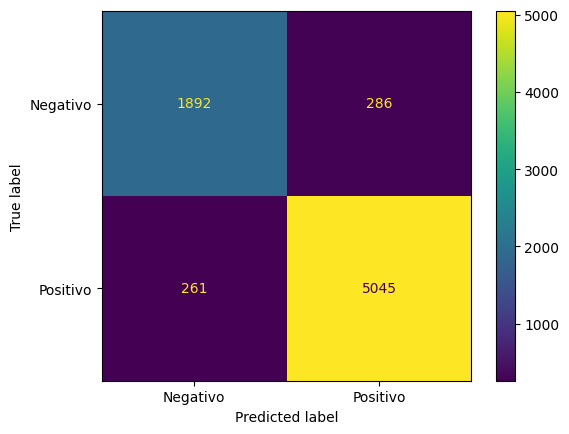

In [8]:
# Fazendo predições no conjunto de teste
y_pred_base = pipeline_base.predict(X_test)
y_proba_base = pipeline_base.predict_proba(X_test)[:, 1] # Probabilidades para a classe positiva (1)

# Relatório de Classificação (inclui Acurácia, Precisão, Recall e F1-Score)
display(Markdown("\n### Relatório de Classificação (Baseline)"))
print(classification_report(y_test, y_pred_base, target_names=['Negativo', 'Positivo']))

# AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_proba_base)
display(Markdown("\n### AUC Score"))
print(f"A AUC do modelo é: {auc:.4f}")

# Matriz de Confusão
display(Markdown("\n### Matriz de Confusão"))
cm = confusion_matrix(y_test, y_pred_base)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negativo', 'Positivo'])
disp.plot()
plt.show()

## **Análise dos Resultados**

O F1-Score de **0.90** para a classe '**Positivo**' e **0.88** para a classe '**Negativ**o' mostra uma performance inicial muito forte.

Como esperado, o desbalanceamento favoreceu ligeiramente a classe majoritária ('Positivo').

A AUC de ~0.97 indica que o modelo já é excelente em distinguir os sentimentos.

Vamos agora tentar melhorar a performance na classe minoritária ('Negativo') usando SMOTE, visando um modelo mais equilibrado.


# Modelo com Balanceamento de Dados (SMOTE)

Aqui, aplicamos a técnica SMOTE para criar um conjunto de treino sinteticamente balanceado, forçando o modelo a dar a mesma importância para ambas as classes.

In [9]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

## Construção e Treinamento do Modelo Baseline

In [10]:
pipeline_smote = ImbPipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('logreg', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
])

# Treinamento do pipeline
print("Iniciando o treinamento do modelo com SMOTE...")
pipeline_smote.fit(X_train, y_train)
print("Modelo treinado com sucesso!")

Iniciando o treinamento do modelo com SMOTE...
Modelo treinado com sucesso!


## Avaliação do Modelo Baseline


### Relatório de Classificação (SMOTE)  

              precision    recall  f1-score   support

    Negativo       0.80      0.94      0.86      2178
    Positivo       0.97      0.91      0.94      5306

    accuracy                           0.91      7484
   macro avg       0.89      0.92      0.90      7484
weighted avg       0.92      0.91      0.92      7484




### AUC Score

A AUC do modelo é: 0.9699



### Matriz de Confusão

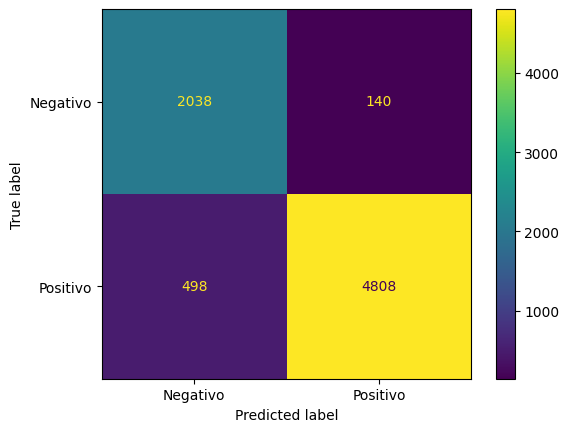

In [11]:
# Fazendo predições no conjunto de teste
y_pred_smote = pipeline_smote.predict(X_test)
y_proba_smote = pipeline_smote.predict_proba(X_test)[:, 1]


display(Markdown("\n### Relatório de Classificação (SMOTE)  "))
print(classification_report(y_test, y_pred_smote, target_names=['Negativo', 'Positivo']))

# AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_proba_smote)
display(Markdown("\n### AUC Score"))
print(f"A AUC do modelo é: {auc:.4f}")

# Matriz de Confusão
display(Markdown("\n### Matriz de Confusão"))
cm = confusion_matrix(y_test, y_pred_smote)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negativo', 'Positivo'])
disp.plot()
plt.show()

## Análise dos resultados


A aplicação do SMOTE otimizou o modelo para a detecção da classe 'Negativo', resultando em um claro trade-off entre precisão e recall.

* Recall (Sensibilidade): Atingiu 0.93, indicando que o modelo agora identifica 93% de todos os feedbacks negativos reais, sendo seu principal ganho de performance.

* Precisão: Caiu para 0.80, o que representa um aumento no número de falsos positivos (feedbacks positivos classificados como negativos).

* F1-Score: O F1-Score resultante para a classe 'Negativo' foi de 0.86. Este valor, ligeiramente inferior ao do baseline (0.88), reflete o foco do modelo em maximizar a detecção (recall) em detrimento da precisão.

# Comparação e Escolha do Modelo Final

A escolha do modelo final baseia-se no objetivo de negócio de **maximizar a identificação de clientes insatisfeitos**, priorizando o Recall da classe 'Negativo'.

O modelo com SMOTE, apesar de ter um F1-Score (0.86) ligeiramente menor que o baseline (0.88), alcança um **Recall** significativamente **superior (0.93)**. Isso o torna a ferramenta mais eficaz para a tarefa crítica de minimizar a quantidade de feedbacks negativos não detectados.

Portanto, o `pipeline_smote` é o modelo escolhido. O custo de negócio de não identificar um cliente insatisfeito supera o de analisar os falsos positivos gerados, alinhando esta escolha à estratégia do projeto.

In [12]:
pipeline = pipeline_smote

# Salvando o Modelo para o Dashboard

* salvar o pipeline treinado. Ele contém tanto o vetorizador quanto o modelo, pronto para ser carregado no nosso aplicativo Streamlit.

In [ ]:
# Define o caminho e o nome do arquivo
MODEL_DIR = '../models'
MODEL_PATH = os.path.join(MODEL_DIR, 'modelo_sentimento.pkl')

# Cria o diretório 'models' se ele não existir
os.makedirs(MODEL_DIR, exist_ok=True)

# Salva o pipeline usando joblib
joblib.dump(pipeline, MODEL_PATH)

print(f"Modelo salvo com sucesso em: {MODEL_PATH}")

Modelo salvo com sucesso em: ../models\pipeline_classificacao_sentimento.pkl


#